# **Recommendation System**

Done by:

1. 18PD05 - Bharathi A
2. 18PD33 - Shreenidhi N

In [ ]:
import os
os.chdir('/content/drive/MyDrive/RL/Package3/Bandits/bandits/single')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Movielens data

In [ ]:
print('reading movielens 1m data')
ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=['UserID','MovieID','Rating','Timestamp'], encoding = "ISO-8859-1")
movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
users = pd.read_csv('data/ml-1m/users.dat', sep='::', names=['UserID','Gender','Age','Occupation', 'Zip'], encoding = "ISO-8859-1")
#ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep=':', usecols=range(0,5,2), names=['UserID','MovieID','Rating'], encoding = "ISO-8859-1")
#movies = pd.read_csv('../data/ml-1m/movies.dat', sep=':', usecols=range(0,5,2), names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
#users = pd.read_csv('../data/ml-1m/users.dat', sep=':', usecols=range(0,7,2), names=['UserID','Gender','Age','Occupation'], encoding = "ISO-8859-1")

#One hot encoding the genres
movies = movies.join(movies['Genres'].str.get_dummies().astype(bool))
print(movies.head())
movies.drop('Genres', inplace=True, axis=1)
ratings['Liked'] = ratings['Rating'].apply(lambda x: 1 if x == 5 else 0)

reading movielens 1m data


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
   MovieID                               Title                        Genres  \
0        1                    Toy Story (1995)   Animation|Children's|Comedy   
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2        3             Grumpier Old Men (1995)                Comedy|Romance   
3        4            Waiting to Exhale (1995)                  Comedy|Drama   
4        5  Father of the Bride Part II (1995)                        Comedy   

   Action  Adventure  Animation  Children's  Comedy  Crim

In [ ]:
top10ids = ratings['MovieID'].value_counts().head(10)
most_rated = movies.loc[movies['MovieID'].isin(top10ids.index)]
print(top10ids.index)

Int64Index([2858, 260, 1196, 1210, 480, 2028, 589, 2571, 1270, 593], dtype='int64')


In [ ]:
ratings_top10 = ratings.loc[ratings['MovieID'].isin(top10ids.index)]
ratings_top10

,UserID,MovieID,Rating,Timestamp,Liked
22,1,1270,5,978300055,1
44,1,260,4,978300760,0
48,1,2028,5,978301619,1
64,2,1210,4,978298151,0
98,2,589,4,978299773,0
...,...,...,...,...,...
999959,6040,1196,3,956715455,0
999982,6040,2571,4,997454126,0
1000033,6040,1210,2,956715805,0
1000074,6040,1270,3,997453960,0


In [ ]:
users_top10 = users.loc[users['UserID'].isin(ratings_top10['UserID'])]
users_top10

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [ ]:
data = pd.merge(ratings_top10, users_top10, on='UserID').sample(frac=1,random_state=5).reset_index(drop=True)
data

,UserID,MovieID,Rating,Timestamp,Liked,Gender,Age,Occupation,Zip
0,5726,2571,1,958495118,0,M,25,1,77845
1,4447,1270,3,965087970,0,M,45,5,32953
2,3509,1196,5,966974612,1,M,18,4,02115
3,2857,260,4,972506196,0,M,25,0,10469
4,1714,2571,5,974706391,1,M,25,17,43212
...,...,...,...,...,...,...,...,...,...
28012,657,2858,4,975693291,0,F,50,13,34691
28013,5679,480,5,958617765,1,M,35,2,33020
28014,4384,2028,5,965172074,1,M,25,0,43623
28015,3978,2028,5,965632133,1,M,35,13,78252


In [ ]:
data['Liked'].unique()

array([0, 1])

Bandit implementations require knowledge of time horizon, number of arms (movies) k, and the reward function for taking action A at time step t. This can influence the performance of the algorithms as the value updates depend on the time horizon. THe time horizon can vary between 0 and the length of dataset, however the expected time horizon is length of dataset / k.

In [ ]:
horizon = len(data.index)*1
k = len(top10ids.index)
M = 10

def reward(t,A):
    t = t % len(data.index)
    if data['MovieID'].iloc[t] == top10ids.index[A]:
        return data['Liked'].iloc[t]
    return None

# Experts 100 random distributions f: age group -> movie
expert = {}
diag = np.zeros((k,k))
np.fill_diagonal(diag, 1)
diag = np.tile(diag,(M,1))
for age in data['Age'].unique():
    new_ks = diag.copy()
    expert[age] = new_ks
    np.random.shuffle(expert[age])

def advice(t):
    t = t % len(data.index)
    return expert[data['Age'].iloc[t]]

print(expert[25])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

# **2. Experiments**

# a. UCB

In [ ]:
# Policy
def UCB_next_action(t, Q, N, c):
    min_action = np.argmin(N)
    if N[min_action] == 0:
        next_action = min_action
    else:
        next_action = np.argmax(Q+c*np.sqrt(np.log(t)/N))
    return next_action

# Value updates and step sizes
def update_weighted_average(t, Q, arm, pulls, reward, alpha):
    Q[arm] = Q[arm] + alpha(t,pulls)*(reward - Q[arm])
    return Q

def const_step(*_):
    return 0.1

def sample_average_step(_,pulls):
    return (1/pulls)

def time_decrease_step(t,_):
    return (1/(t+1))

# Bandit interaction
def UCB(k,reward,horizon,c=2,step_size=sample_average_step):
    all_rewards = []
    Q = np.zeros(k)
    N = np.zeros(k)
    t_hit = 0
    for t in range(horizon):
        A = UCB_next_action(t_hit,Q,N,c)
        X = reward(t,A)
        if X is not None:
            N[A] += 1
            Q = update_weighted_average(t_hit,Q,A,N[A],X,step_size)
            all_rewards.append(X)
            t_hit += 1
    return all_rewards

# b. Exp3

In [ ]:
# Policy
def exp3_next_action(S, c):
    P = np.exp(c*S)/np.sum(np.exp(c*S))
    return np.random.choice(len(P),p=P), P

# Action weight update
def update_importance_weighted(S,arm,reward,P):
    S[arm] = S[arm] + reward/P[arm]
    return S

# Bandit interaction
def Exp3(k,reward,horizon,eta):
    all_rewards = []
    S = np.zeros(k)
    for t in range(horizon):
        A, P = exp3_next_action(S, eta)
        X = reward(t,A)
        if X is not None:
            S = update_importance_weighted(S,A,X,P)
            all_rewards.append(X)
    return all_rewards

# c. Exp4

In [ ]:
# Policy
def exp4_next_action(Q, E):
    P = np.matmul(Q,E)
    return np.random.choice(len(P),p=P), P

# Expert weight update
def update_importance_weighted_with_experts(Q,E,arm,reward,P,c):
    X_hat = update_importance_weighted(np.zeros(E.shape[1]),arm,reward,P)
    X_tilde = np.dot(E,X_hat)
    Q = np.multiply(np.exp(c*X_tilde),Q)/np.sum(np.multiply(np.exp(c*X_tilde),Q))
    return Q

# Bandit interaction
def Exp4(M,reward,horizon,c,advice):
    all_rewards = []
    Q = np.full(M,1/M)
    for t in range(horizon):
        E = advice(t)
        A, P = exp4_next_action(Q,E)
        X = reward(t,A)
        if X is not None:
            Q = update_importance_weighted_with_experts(Q,E,A,X,P,c)
            all_rewards.append(X)
    return all_rewards

In [ ]:
ucb = UCB(k,reward,horizon)

In [ ]:
eta = np.sqrt(2*np.log(k)/(horizon*k))
exp3 = Exp3(k,reward,horizon,eta)

In [ ]:
eta = np.sqrt(2*np.log(M)/(horizon*k))
exp4 = Exp4(M*k,reward,horizon,eta,advice)

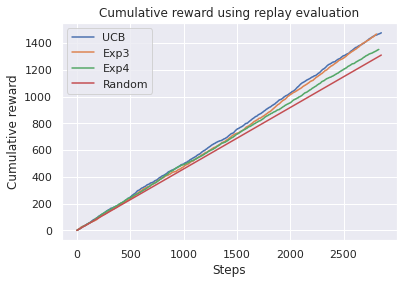

In [ ]:
random = np.full(len(ucb),data['Liked'].value_counts(normalize=True)[1])

fig1, ax1 = plt.subplots()
ax1.plot(range(len(ucb)), np.cumsum(ucb), label='UCB')
ax1.plot(range(len(exp3)), np.cumsum(exp3), label='Exp3')
ax1.plot(range(len(exp4)), np.cumsum(exp4), label='Exp4')
ax1.plot(range(len(random)), np.cumsum(random), label='Random')
ax1.set_title("Cumulative reward using replay evaluation")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
plt.legend()

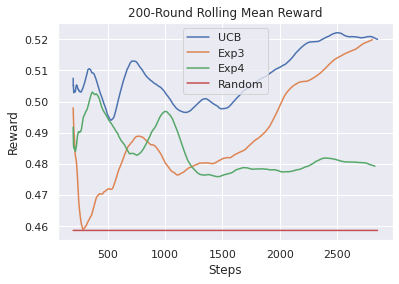

In [ ]:
cumulative_random = np.cumsum(random) / np.linspace(1, len(random), len(random))
cumulative_ucb = np.cumsum(ucb) / np.linspace(1, len(ucb), len(ucb))
cumulative_exp3 = np.cumsum(exp3) / np.linspace(1, len(exp3), len(exp3))
cumulative_exp4 = np.cumsum(exp4) / np.linspace(1, len(exp4), len(exp4))

fig1, ax1 = plt.subplots()
ax1.plot(range(len(ucb)), np.asarray(pd.Series(cumulative_ucb).rolling(200).mean()), label='UCB')
ax1.plot(range(len(exp3)), np.asarray(pd.Series(cumulative_exp3).rolling(200).mean()), label='Exp3')
ax1.plot(range(len(exp4)), np.asarray(pd.Series(cumulative_exp4).rolling(200).mean()), label='Exp4')
ax1.plot(range(len(random)), np.asarray(pd.Series(cumulative_random).rolling(200).mean()), label='Random')
ax1.set_title("200-Round Rolling Mean Reward")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Reward")
plt.legend()